## LDA

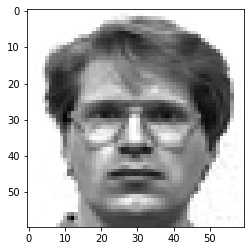

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

HEIGHT = 60
WIDTH = 60

def load_img(path, height=HEIGHT, width=WIDTH):
    label = []
    img_list = []
    for file in os.listdir(f'Yale_Face_Database/{path}'):
        subject = int(file[7:9])
        img = Image.open(f'Yale_Face_Database/{path}/{file}')
        img = img.resize((height,width), Image.ANTIALIAS)
        
        label.append(subject)
        img_list.append(np.array(img).reshape(-1)) # Flatten 100x100 to 10000 features
        plt.imshow(img, cmap='gray')
    return np.array(img_list), np.array(label) #(135,10000) (135,)

img, label = load_img('Training')
test_x, test_y = load_img('Testing')

all_img = np.concatenate([img,test_x])
all_label = np.concatenate([label, test_y])

## Eigenfaces Reconstruction
####  Mean

In [2]:
all_label = all_label-1 # Original label start from 1~15
all_mean = np.mean(all_img, axis=0)
label_mean = np.zeros([len(set(all_label)),all_img.shape[1]])

for i in list(set(all_label)):
    label_mean[i] = np.mean(all_img[all_label==(i)], axis=0)

#### Within-class scatter & Between-class scatter
$S_{B} \mathrm{w}=\lambda S_{W} \mathrm{w}$

In [3]:
def WithinClass(data, label, classmean):
    withinclass = np.zeros([data.shape[1], data.shape[1]]) # (10000,10000)
    for i in range(data.shape[0]):
        dist = (data[i] - classmean[label[i]]).reshape(-1,1) # (10000,) - (10000)
        withinclass += dist@dist.T # (10000,1)@(1,10000)

    return withinclass

def BetweenClass(label, classmean, allmean):
    betweenclass = np.zeros([classmean.shape[1], classmean.shape[1]]) # (10000,10000)
    for i in range(len(set(label))):
        dist = (classmean[i] - allmean[i]).reshape(-1,1) # (10000 - 1)
        betweenclass += dist@dist.T
        
    return betweenclass

def LDA(data):
    Sw = WithinClass(data, all_label, label_mean)
    Sb = BetweenClass(all_label, label_mean, all_mean)

    eigenvalue, eigenvector = np.linalg.eigh(np.linalg.pinv(Sw) @ Sb)
    idx = np.argsort(eigenvalue)[::-1] # Select the largest k eigenvalue
    idx = idx[:25]
    vector = eigenvector[:,idx]
    
    return data@vector, vector

lda, eigenvector = LDA(all_img)

train_lda = lda[:len(img)]
test_lda = lda[len(img):]

recon = train_lda @ eigenvector.T

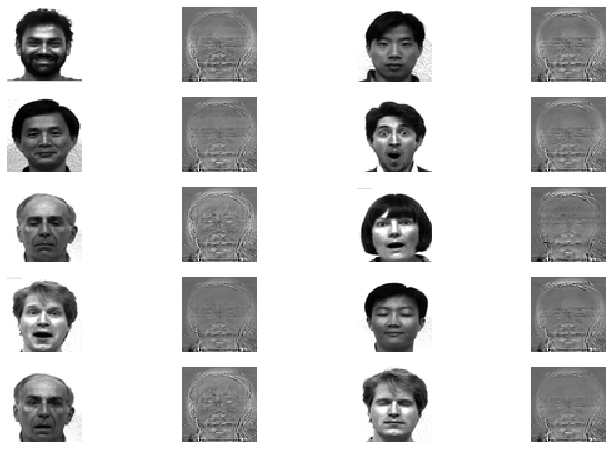

In [4]:
num_sample = 10
rand_idx = np.random.choice(len(img), num_sample, replace=False)
plt.figure(figsize=(12,8))
for i in range(num_sample*2):
    if i%2 == 0:
        plt.subplot(num_sample//2,4,i+1)
        plt.axis('off')
        plt.imshow(img[rand_idx[i//2]].reshape(HEIGHT,WIDTH), cmap='gray')
    else:
        plt.subplot(num_sample//2,4,i+1)
        plt.axis('off')
        plt.imshow(recon[rand_idx[i//2]].reshape(HEIGHT,WIDTH), cmap='gray')
    #plt.tight_layout()

## Face Recognition (KNN)

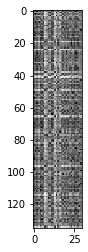

In [5]:
from scipy.spatial.distance import cdist

distance = cdist(train_lda, test_lda)
_ = plt.imshow(distance, interpolation='none', cmap='gray')


k = 1, accuracy = 0.8666666666666667
k = 3, accuracy = 0.8666666666666667
k = 5, accuracy = 0.8666666666666667
k = 8, accuracy = 0.8666666666666667
k = 10, accuracy = 0.8666666666666667
k = 12, accuracy = 0.8666666666666667
k = 15, accuracy = 0.8333333333333334
k = 20, accuracy = 0.7333333333333333
k = 50, accuracy = 0.36666666666666664
k = 100, accuracy = 0.16666666666666666


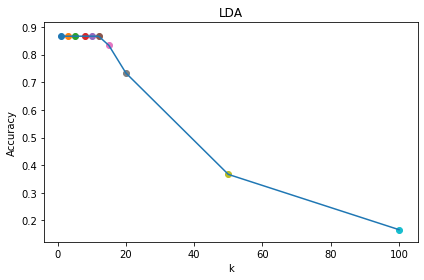

In [6]:
def create_dict():
    dic = {}
    for name in set(label):
        dic[name] = 0
    return dic

create_dict()

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

def KNN(k, train, test, test_label):
    
    acc = 0
    distance = cdist(train, test)

    for i in range(len(test)):
        dic = create_dict()
        idx = np.argsort(distance[:,i])[:k]

        for j in idx:
            dic[label[j]] += 1

        if max(dic, key=dic.get) == test_label[i]:
            acc += 1
                     
    return acc/len(test)

score = []
for i in k_choices:
    acc = KNN(i, train_lda, test_lda, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)

    

plt.plot(k_choices, score)
plt.title('LDA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()

## Kernel LDA

In [7]:
from scipy.spatial.distance import pdist, squareform

def Kernel_LDA(data, target, method):

    if method=='rbf':
        gamma = 1e-5
        K = np.exp(-gamma * squareform(pdist(data), 'sqeuclidean')) # (135,135)
        
    elif method=='linear':
        K = data @ data.T # (135,135)

    M = np.zeros([data.shape[0], data.shape[0]])
    for i in range(15):
        classM = K[np.where(target == i)[0]].copy()
        classM = np.sum(classM, axis=0).reshape(-1, 1) / 11
        allM = K[np.where(target == i)[0]].copy()
        allM = np.sum(allM, axis=0).reshape(-1, 1) / data.shape[0]
        dist = classM - allM
        multiplydist = 11 * dist@dist.T
        M += multiplydist

    N = np.zeros([data.shape[0], data.shape[0]])
    I_minus_one = np.identity(11) - (11 * np.ones((11, 11)))
    for i in range(15):
        Kj = K[np.where(target == i)[0]].copy()
        multiply = Kj.T @ I_minus_one @ Kj
        N += multiply

    eigenvalue, eigenvector = np.linalg.eigh(np.linalg.pinv(N) @ M)
    idx = np.argsort(eigenvalue)[::-1] # Select the largest k eigenvalue
    idx = idx[:25]
    vector = eigenvector[:,idx]

    return (K @ vector), vector

### RBF Kernel

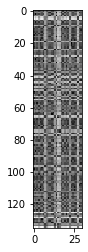

k = 1, accuracy = 0.7666666666666667
k = 3, accuracy = 0.7333333333333333
k = 5, accuracy = 0.7333333333333333
k = 8, accuracy = 0.6666666666666666
k = 10, accuracy = 0.6333333333333333
k = 12, accuracy = 0.7
k = 15, accuracy = 0.6666666666666666
k = 20, accuracy = 0.6
k = 50, accuracy = 0.16666666666666666
k = 100, accuracy = 0.1


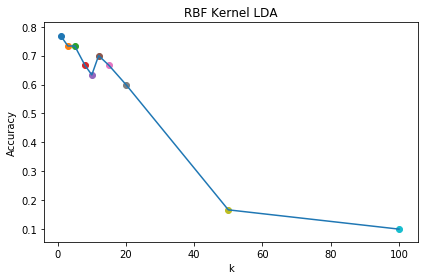

In [8]:
kernel_lda, vector = Kernel_LDA(all_img, all_label, 'rbf')
train_kernel_lda = kernel_lda[:len(img)]
test_kernel_lda = kernel_lda[len(img):]

distance = cdist(train_kernel_lda, test_kernel_lda)
plt.imshow(distance, interpolation='none', cmap='gray')
plt.show()

score = []
for i in k_choices:
    acc = KNN(i, train_kernel_lda, test_kernel_lda, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)

    

plt.plot(k_choices, score)
plt.title('RBF Kernel LDA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()

### Linear Kernel

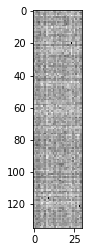

k = 1, accuracy = 0.26666666666666666
k = 3, accuracy = 0.1
k = 5, accuracy = 0.13333333333333333
k = 8, accuracy = 0.2
k = 10, accuracy = 0.1
k = 12, accuracy = 0.1
k = 15, accuracy = 0.13333333333333333
k = 20, accuracy = 0.1
k = 50, accuracy = 0.23333333333333334
k = 100, accuracy = 0.16666666666666666


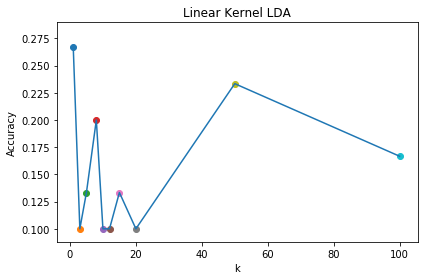

In [9]:
kernel_lda, vector = Kernel_LDA(all_img, all_label, 'linear')
train_kernel_lda = kernel_lda[:len(img)]
test_kernel_lda = kernel_lda[len(img):]

distance = cdist(train_kernel_lda, test_kernel_lda)
plt.imshow(distance, interpolation='none', cmap='gray')
plt.show()

score = []
for i in k_choices:
    acc = KNN(i, train_kernel_lda, test_kernel_lda, test_y)
    score.append(acc) 
    print(f'k = {i}, accuracy = {acc}') 
    plt.scatter(i, acc)

    

plt.plot(k_choices, score)
plt.title('Linear Kernel LDA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()